In [1]:
#Requiered libraries
import pandas as pd
import os
import numpy as np
from datetime import date
import datetime
from keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomBrightness
from tensorflow.keras.layers import RandomContrast 
from tensorflow.keras.layers import RandomTranslation

# For evaluating performance
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

#Tensorboard
import io
import itertools
from packaging import version
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import datetime
%load_ext tensorboard

In [2]:
#Reading the dataset


DATE= date.today().strftime("%Y_%m_%d")
DATASET_PATH_train = r"C:\Users\Alex\Documents\GitHub\may25_bds_plants\05_data\original_data\2.1.1 New Plant Diseases\train"

DATASET_PATH_valid = r"C:\Users\Alex\Documents\GitHub\may25_bds_plants\05_data\original_data\2.1.1 New Plant Diseases\valid"


In [3]:
#Constant variables

IMAGE_SIZE = (128,128, 3)  # (height, width, channels)
vector_size_1D = IMAGE_SIZE[0] * IMAGE_SIZE[1] * IMAGE_SIZE[2]  # Flattened size for each image
batch_size = 64


In [4]:
train = image_dataset_from_directory(
    DATASET_PATH_train,  # Path to the dataset
    labels='inferred',  # Automatically infer labels from subdirectory names
    #label_mode='categorical',  # Use categorical labels
    image_size=IMAGE_SIZE[:2],  # Resize images to the specified size
    batch_size=batch_size,  # Number of images per batch
    seed=42,  # Random seed for reproducibility
    )

class_names = train.class_names #Saves all class names in a list 
classes_healthy = [class_name for class_name in train.class_names if "healthy" in class_name.lower()]
classes_sick = [class_name for class_name in train.class_names if "healthy" not in class_name.lower()]

# Validation dataset
valid = image_dataset_from_directory(
    DATASET_PATH_valid,  # Path to the dataset
    labels='inferred',  # Automatically infer labels from subdirectory names
    #label_mode='categorical',  # Use categorical labels
    image_size=IMAGE_SIZE[:2],  # Resize images to the specified size
    batch_size=batch_size,  # Number of images per batch
    seed=42,  # Random seed for reproducibility
    )


Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [5]:
dataset = train #Choose the dataset to work with, e.g., train, valid, test_healthy, test_sick
dataset_valid = valid #Choose the dataset to work with, e.g., train, valid, test_healthy, test_sick


dataset.class_names = sorted(dataset.class_names)  # Sort class names for consistency
print(dataset.class_names)

for image_batch, labels_batch in dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:


# Configuration for performance optimization
# This is used to optimize the performance of data loading and preprocessing
AUTOTUNE = tf.data.AUTOTUNE
# Apply performance optimizations to the datasets
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
dataset_valid = dataset_valid.cache().prefetch(buffer_size=AUTOTUNE)

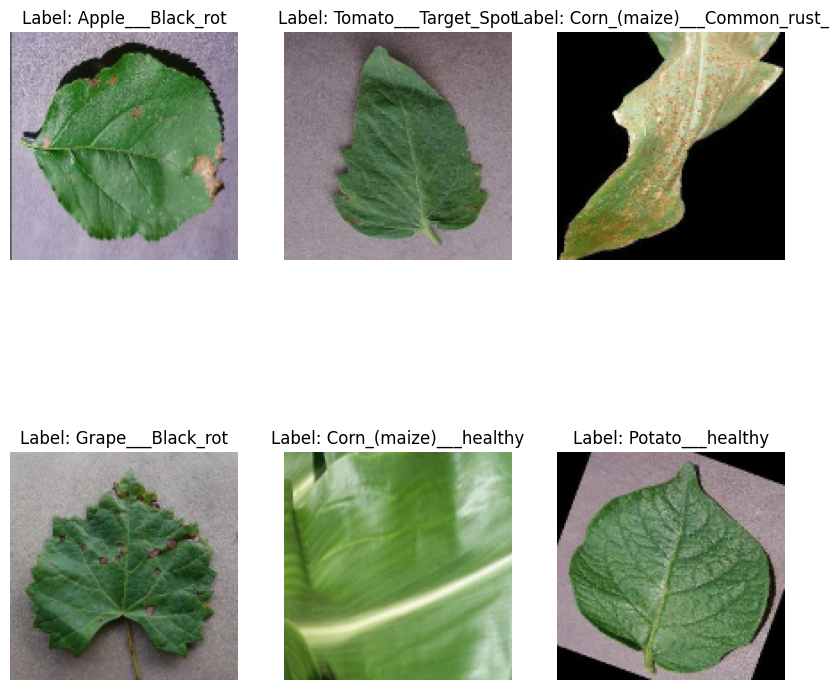

In [40]:
# Define the number of images to display
number_of_images = 6

# Create a figure for displaying
plt.figure(figsize=(10,10))

# Get a batch of images from train_healthy
for images, labels in dataset.take(1):
    # Display the images from the batch
    for i in range(number_of_images):
        ax = plt.subplot(2, 3, i + 1) 
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert the image to integer for display
        plt.axis("off") 
        plt.title(f"Label: {class_names[labels[i]]}")  # Display the label of the image
        # labels[i] gives back the number of the folder, e.g 0 stands for apple(1.Folder), 3 for corn(4.Folder), etc.
# Show the images
plt.show()

In [41]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,
                               mode='min',
                               restore_best_weights=True)

ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.5, 
                                      patience=2,
                                      #cooldown=2,
                                      #min_delta=0.01,
                                      mode='min',  # Reduce learning rate when validation loss is not improving
                                      verbose=1) 

# For evaluating performance
checkpoint = ModelCheckpoint(
    filepath=rf"C:\Users\Alex\Documents\GitHub\may25_bds_plants\05_data\Model\model_{DATE}.keras",  # Save the model with a timestamp
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # Save when validation loss is minimized
    #verbose=1  # Verbose output
    )   




In [42]:
#For Tensorboard 
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

from datetime import datetime

logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Using the file writer, log the reshaped image.

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,  histogram_freq=1)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')


def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image


def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  #test_pred_raw = model.predict(dataset_valid) 
  y_true = np.concatenate([labels.numpy() for images, labels in dataset_valid], axis=0)
  #test_pred = np.argmax(test_pred_raw, axis=1)
  y_pred = np.argmax(model.predict(dataset_valid), axis=1)

  # Calculate the confusion matrix.
  #cm = sklearn.metrics.confusion_matrix(dataset_valid, test_pred)
  cm = confusion_matrix(y_true, y_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("epoch_confusion_matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)




In [43]:
#First Model
# Define the input layer with the specified image size
inputs = Input(shape = IMAGE_SIZE)
x = Rescaling(1./255)(inputs)  # Normalize pixel values to [0, 1]
x = Conv2D(filters = 32, 
           kernel_size=(5, 5), 
           activation='relu')(x)  # Apply a convolutional layer
x = MaxPooling2D(pool_size=(2, 2))(x)  # Apply max pooling to reduce dimensionality
x = Dropout(0.2)(x)  # Apply dropout for regularization
x = Flatten()(x)  # Flatten the image to a 1D vector
x = Dense(128, activation='relu')(x)  # Fully connected layer with 128 units
outputs = Dense(len(class_names), activation='softmax')(x)  # Output layer with softmax activation for multi-class classification

model = Model(inputs=inputs, outputs=outputs)

print(model.summary())  # Print the model summary to see the architecture
display(model.summary())

import json

save_dir = r"C:\Users\Alex\Documents\GitHub\may25_bds_plants\01_notebooks\02_preprossing"
save_path = os.path.join(save_dir, "first_model_layers.json")

layer_info = []
for layer in model.layers:
    info = {
        "name": layer.name,
        "class": layer.__class__.__name__,
        "params": layer.count_params()
    }

    # Optional: output_shape prüfen
    try:
        info["output_shape"] = str(layer.output.shape)
    except AttributeError:
        info["output_shape"] = "n/a"

    # Sicher prüfen auf activation
    try:
        info["activation"] = layer.activation.__name__
    except AttributeError:
        info["activation"] = "n/a"

    layer_info.append(info)

with open("first_model_layers.json", "w") as f:
    json.dump(layer_info, f, indent=2)

print(f"Summary gespeichert unter: {save_path}")

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Compile the model with categorical crossentropy loss and Adam optimizer
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Start TensorBoard.
# put in bash : tensorboard --logdir logs/image

# Train the model on the training dataset
dataset_history = model.fit(dataset,
                    validation_data=valid,
                    epochs=10,
                    callbacks=[early_stopping,
                                ReduceLROnPlateau, 
                                checkpoint, 
                                tensorboard_callback,
                                cm_callback]
                    )

#Save the model
model.save(rf"C:\Users\Alex\Documents\GitHub\may25_bds_plants\05_data\Model\model_{DATE}.keras")

with open(rf"model_history_{DATE}.json", "w") as f:
    json.dump(dataset_history.history, f)


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_20 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,752,486 (60.09 MB)

 Trainable params: 15,752,486 (60.09 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_20 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,752,486 (60.09 MB)

 Trainable params: 15,752,486 (60.09 MB)

 Non-trainable params: 0 (0.00 B)

None

Summary gespeichert unter: C:\Users\Alex\Documents\GitHub\may25_bds_plants\01_notebooks\02_preprossing\first_model_layers.json
You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.4486 - loss: 2.2771WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F2A5A83560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  m

In [11]:
dataset_acc = dataset_history.history['accuracy']
val_acc = dataset_history.history['val_accuracy']
dataset_history.history["loss"]

NameError: name 'dataset_history' is not defined

In [7]:
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\Alex\Documents\GitHub\may25_bds_plants\05_data\models\model_2025_07_29.keras")


NameError: name 'dataset_history' is not defined

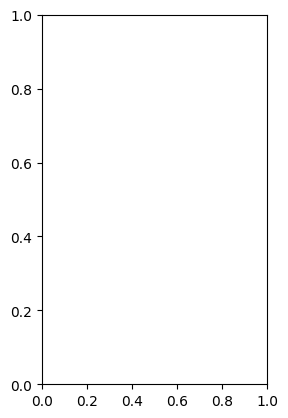

In [8]:
#plt.figure(fig_size=(10,8))
plt.subplot(121)
plt.plot(dataset_history.history['loss'])
plt.plot(dataset_history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')

plt.subplot(122)
plt.plot(dataset_history.history['accuracy'])
plt.plot(dataset_history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.show()

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       504
           1       0.90      0.88      0.89       497
           2       0.89      0.90      0.89       440
           3       0.87      0.76      0.81       502
           4       0.93      0.90      0.92       454
           5       0.92      0.90      0.91       421
           6       0.94      0.92      0.93       456
           7       0.87      0.80      0.84       410
           8       0.96      0.99      0.98       477
           9       0.86      0.91      0.88       477
          10       0.96      0.99      0.97       465
          11       0.91      0.80      0.85       472
          12       0.83      0.95      0.88       480
          13       0.97      0.96      0.97       430
          14       0.94      0.96      0.95       423
          15       0.88      0.98      0.93       503
          16       0.83      0.82      0.83       459
          17       0.93    

<Axes: >

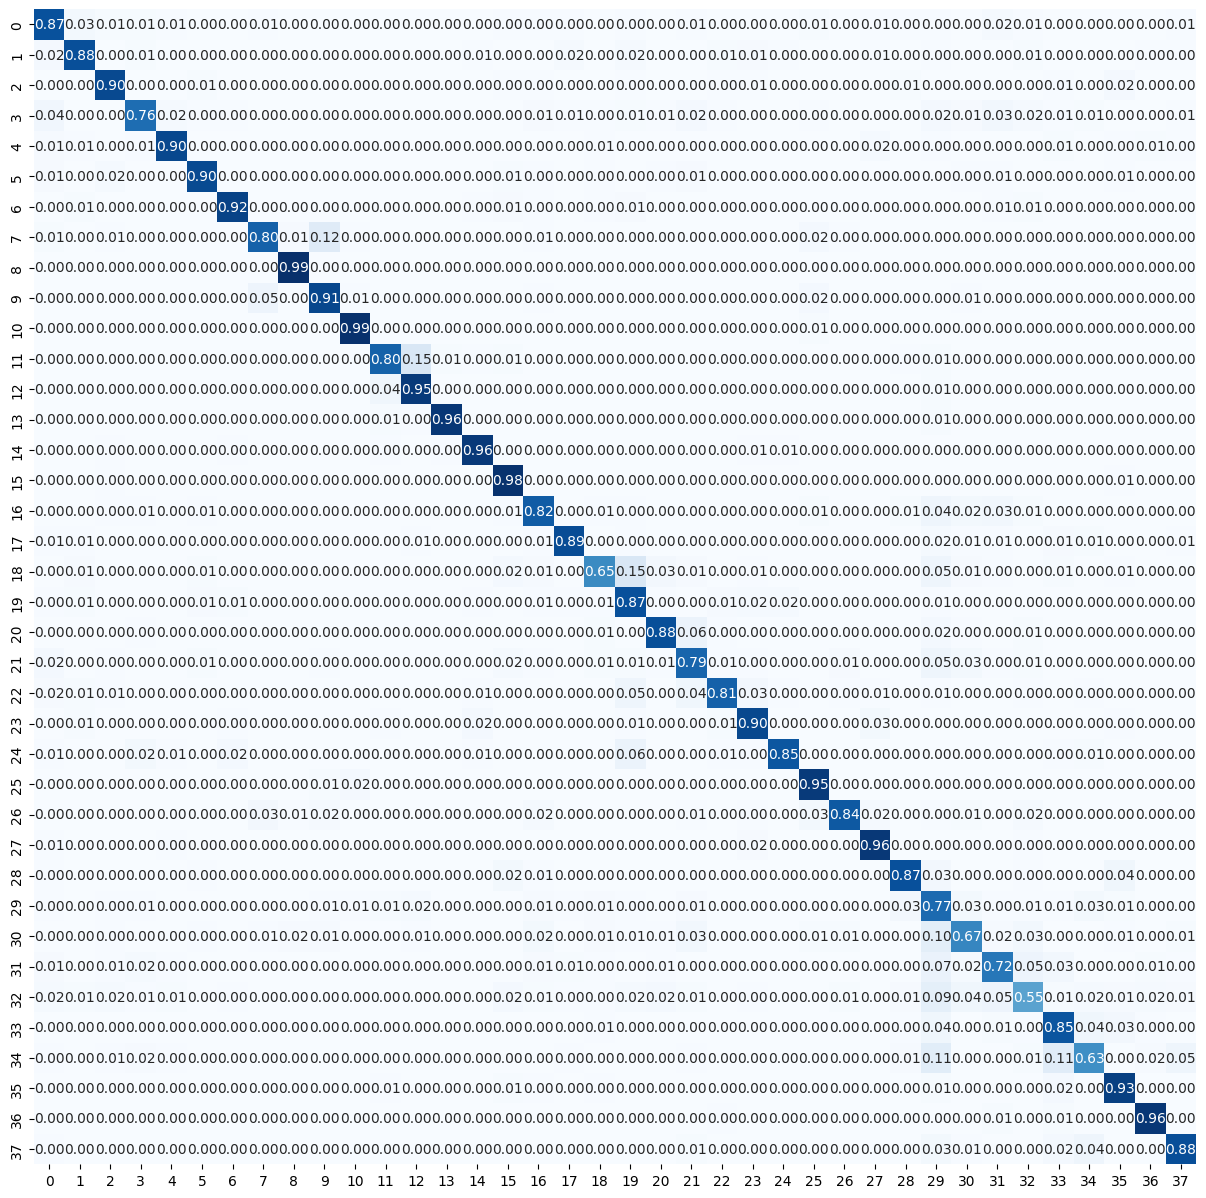

In [9]:
import seaborn as sns

def get_predictions_and_labels(dataset):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        
        preds = model.predict(images, verbose=0)  # Get the model's predictions
        pred_labels.extend(np.argmax(preds, axis=-1))  # Get the predicted labels (argmax)

        true_labels.extend(labels.numpy())  # Get the true labels

    return np.array(true_labels), np.array(pred_labels)

def generate_classification_report(y_true, y_pred):
    return classification_report(y_true, y_pred, output_dict=True)

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Normalized Confusion Matrix")
    return fig


y_true, y_pred = get_predictions_and_labels(dataset_valid)  # Get true labels and predictions from the test dataset

# Display the classification report
print(classification_report(y_true, y_pred))  # Print the classification report (precision, recall, F1-score)

# Display the confusion matrix
plt.figure(figsize=(15, 15))  # Create a large figure for the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')  # Compute the normalized confusion matrix
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt=".2f")  # Plot the confusion matrix as a heatmap

In [ ]:
import pickle

report = classification_report(y_true, y_pred, output_dict=True)
cmatrix = confusion_matrix(y_true, y_pred, normalize='true')

with open("first_model_classification_results_2025_07_29.pkl", "wb") as f:
    pickle.dump({
        "y_true": y_true,
        "y_pred": y_pred,
        "report": report,
        "confusion_matrix": cmatrix
    }, f)

In [81]:
#Grad-CAM: Visualizing Decisions

#Selection 4 images from the validation dataset
X = np.array([img.numpy() for img, _ in dataset_valid.take(2)][0]).astype(np.uint8)
y = np.array([label.numpy() for _, label in dataset_valid.take(2)][0])

# Select specific images
images = X[:4]
labels = y[:4]

In [19]:
def grad_cam(image, model, layer_name):
    if not any(layer.name == layer_name for layer in model.layers):
        raise ValueError(f"Layer {layer_name} not found in model.")
    # Retrieve the convolutional layer
    layer = model.get_layer(layer_name)
    
    # Create a model that generates the outputs of the convolutional layer and the predictions
    grad_model = Model(inputs=model.input, outputs=[layer.output, model.output])

    # Add a batch dimension
    image = tf.expand_dims(image, axis=0)

    # Compute the gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        predicted_class = tf.argmax(predictions[0])  # Predicted class
        loss = predictions[:, predicted_class]  # Loss for the predicted class

    # Gradients of the scores with respect to the outputs of the convolutional layer
    grads = tape.gradient(loss, conv_outputs)

    # Weighted average of the gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the activations by the calculated gradients
    conv_outputs = conv_outputs[0]  # Remove the batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0)  # Focus only on positive values
    heatmap /= tf.math.reduce_max(heatmap) + 1e-6  # Normalize between 0 and 1
    heatmap = heatmap.numpy()  # Convert to numpy array for visualization

    # Resize the heatmap to match the original image size
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (image.shape[1], image.shape[2])).numpy()
    heatmap_resized = np.squeeze(heatmap_resized, axis=-1)  # Remove the singleton dimension at the end of the heatmap_resized array

    # Color the heatmap with a palette (e.g., "jet")
    heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3]  # Get the R, G, B channels 

    superimposed_image = heatmap_colored * 0.7 + image[0].numpy() / 255.0

    return np.clip(superimposed_image, 0, 1), predicted_class

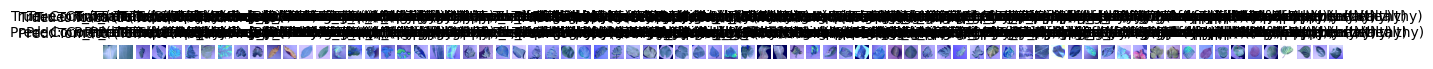

In [42]:
import os
from PIL import Image

def format_class_name(label):
    plant, disease = label.split("___")
    return f"{plant} ({disease.replace('_', ' ')})"

def show_grad_cam_cnn(images, labels, model, class_names, save_dir=None):
    os.makedirs(save_dir, exist_ok=True) if save_dir else None

    number_of_images = images.shape[0]
    conv_layers = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]
    conv_layers = conv_layers[-1:]  # Use only the last convolutional layer for Grad-CAM
    
    plt.figure(figsize=(16,16))

    for j, layer in enumerate(conv_layers):

        for i in range(number_of_images):

            subplot_index = i + 1 + j * number_of_images
            plt.subplot(len(conv_layers), number_of_images, subplot_index)

            # Get the image with the overlaid heatmap
            grad_cam_image, predicted_class = grad_cam(images[i], model, layer)
            true_label = format_class_name(class_names[labels[i]])
            predicted_label = format_class_name(class_names[predicted_class])
            
            # Display the image with Grad-CAM
            #plt.title(f'Grad-CAM {layer}')
            plt.title(f'True: {true_label}\nPred: {predicted_label}', fontsize=10)
            plt.imshow(grad_cam_image)
            plt.axis("off")

            if save_dir:
                filename = f"{class_names[labels[i]]}_img{i+1}.jpg"
                filepath = os.path.join(save_dir, filename)
                gradcam_uint8 = (grad_cam_image * 255).astype(np.uint8)
                Image.fromarray(gradcam_uint8).save(filepath)

    if not save_dir:
        plt.show()
#-------------------------------------------------------------
#Damit wir zwei Bilder pro Klasse haben, iterieren wir durch das Validierungsset
from collections import defaultdict

# Ziel: Zwei Bilder pro Klasse (z. B. 'Apple___healthy', 'Tomato___Early_blight', …)
images_by_class = defaultdict(list)

# Iteriere durch das gesamte Validierungsset
for images, labels in dataset_valid:
    for img, label in zip(images, labels):
        label_int = int(label.numpy())
        if len(images_by_class[label_int]) < 2:
            images_by_class[label_int].append(img.numpy())
        # Abbruchbedingung: wenn alle Klassen 2 Bilder haben
        if all(len(v) >= 2 for v in images_by_class.values()):
            break
    if all(len(v) >= 2 for v in images_by_class.values()):
        break

# Jetzt alle gesammelten Bilder & Labels extrahieren
all_images = []
all_labels = []

for label, imgs in images_by_class.items():
    all_images.extend(imgs)
    all_labels.extend([label] * len(imgs))

# In Arrays umwandeln
all_images = np.array(all_images).astype(np.uint8)
all_labels = np.array(all_labels)

#-------------------------------------------------------------------

#show_grad_cam_cnn(images, model)
save_path = r"C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_grad_cam\first_model_2025_07_29"
#show_grad_cam_cnn(images, labels, model, class_names, save_dir=save_path) #für 4 bilder 

show_grad_cam_cnn(all_images, all_labels, model, class_names, save_dir=save_path) #für alle bilder


In [80]:
%pip install shap

#Shap
import shap
masker = shap.maskers.Image("inpaint_telea", images[0].shape) # inpaint_telea blurs the image regions to explain 

explainer = shap.Explainer(model, masker, output_names=class_names)

shap_values = explainer(images, 
                        max_evals=500,  
                        outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values)

Note: you may need to restart the kernel to use updated packages.


AttributeError: EagerTensor object has no attribute 'ravel'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [ ]:
#Sehr ausführliche Erklärungen mit SHAP und weiteren Methoden, die aber nicht verwendet  wird.

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict
import cv2
from scipy import ndimage

def save_explainable_images_robust(model, dataset, class_names, save_dir, samples_per_class=2):
    """
    Robuste Alternative zu SHAP - verwendet mehrere bewährte Explanation-Methoden
    die garantiert funktionieren und sichtbare Ergebnisse liefern.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Bilder nach Klasse sammeln
    images_by_class = defaultdict(list)
    
    print("🔍 Sammle Bilder pro Klasse...")
    for batch_images, batch_labels in dataset.take(50):
        for img, label in zip(batch_images, batch_labels):
            if len(label.shape) > 0 and label.shape[-1] > 1:
                label_val = int(tf.argmax(label).numpy())
            else:
                label_val = int(label.numpy())
            
            if len(images_by_class[label_val]) < samples_per_class:
                images_by_class[label_val].append(img.numpy())
            
            if all(len(imgs) >= samples_per_class for imgs in images_by_class.values()):
                break
        
        if all(len(imgs) >= samples_per_class for imgs in images_by_class.values()):
            break
    
    print(f"📊 Gefunden: {len(images_by_class)} Klassen")
    
    # Für jede Klasse Explanations erstellen
    for class_idx, images in images_by_class.items():
        class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class_{class_idx}"
        
        print(f"\n🔍 Verarbeite Klasse: {class_name}")
        
        for i, img in enumerate(images):
            create_comprehensive_explanation(
                img, model, class_names, class_name, i, save_dir
            )

def create_comprehensive_explanation(image, model, class_names, class_name, img_idx, save_dir):
    """
    Erstellt umfassende Explanations mit mehreren bewährten Methoden
    """
    try:
        # Bild normalisieren
        if image.max() > 1.0:
            img_norm = image.astype(np.float32) / 255.0
        else:
            img_norm = image.astype(np.float32)
        
        print(f"   📸 Bild {img_idx+1}: Shape {img_norm.shape}, Range [{img_norm.min():.3f}, {img_norm.max():.3f}]")
        
        # Model prediction
        img_batch = np.expand_dims(img_norm, axis=0)
        predictions = model.predict(img_batch, verbose=0)
        pred_class = np.argmax(predictions[0])
        confidence = predictions[0][pred_class]
        pred_name = class_names[pred_class] if pred_class < len(class_names) else f"Class_{pred_class}"
        
        print(f"   🎯 Prediction: {pred_name} ({confidence:.3f})")
        
        # 1. Vanilla Gradients
        vanilla_grads = compute_vanilla_gradients(img_norm, model, pred_class)
        
        # 2. Integrated Gradients  
        integrated_grads = compute_integrated_gradients(img_norm, model, pred_class)
        
        # 3. GradCAM (falls CNN)
        gradcam = compute_gradcam(img_norm, model, pred_class)
        
        # 4. Occlusion-based explanation
        occlusion_map = compute_occlusion_sensitivity(img_norm, model, pred_class)
        
        # 5. Noise-based explanation
        noise_map = compute_noise_sensitivity(img_norm, model, pred_class)
        
        # Alle Ergebnisse visualisieren
        create_explanation_plot(
            img_norm, vanilla_grads, integrated_grads, gradcam, 
            occlusion_map, noise_map, pred_name, confidence, 
            class_name, img_idx, save_dir
        )
        
    except Exception as e:
        print(f"   ❌ Fehler bei Bild {img_idx+1}: {e}")
        import traceback
        traceback.print_exc()

def compute_vanilla_gradients(image, model, pred_class):
    """Berechnet standard Gradients"""
    try:
        img_tensor = tf.Variable(image[np.newaxis, ...], dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            predictions = model(img_tensor)
            target_score = predictions[0][pred_class]
        
        gradients = tape.gradient(target_score, img_tensor)
        
        if gradients is not None:
            grads = gradients.numpy()[0]
            # Magnitude über Kanäle
            if len(grads.shape) == 3:
                grad_magnitude = np.mean(np.abs(grads), axis=-1)
            else:
                grad_magnitude = np.abs(grads)
            
            print(f"     ✅ Vanilla Gradients: {grad_magnitude.min():.6f} to {grad_magnitude.max():.6f}")
            return grad_magnitude
        else:
            print(f"     ❌ Vanilla Gradients: None returned")
            return np.zeros(image.shape[:2])
            
    except Exception as e:
        print(f"     ❌ Vanilla Gradients Error: {e}")
        return np.zeros(image.shape[:2])

def compute_integrated_gradients(image, model, pred_class, steps=20):
    """Berechnet Integrated Gradients"""
    try:
        baseline = np.zeros_like(image)
        integrated_grads = []
        
        for step in range(steps + 1):
            alpha = step / steps
            interpolated = baseline + alpha * (image - baseline)
            
            img_tensor = tf.Variable(interpolated[np.newaxis, ...], dtype=tf.float32)
            
            with tf.GradientTape() as tape:
                predictions = model(img_tensor)
                target_score = predictions[0][pred_class]
            
            gradients = tape.gradient(target_score, img_tensor)
            if gradients is not None:
                integrated_grads.append(gradients.numpy()[0])
        
        if integrated_grads:
            # Durchschnitt der Gradienten * (image - baseline)
            avg_grads = np.mean(integrated_grads, axis=0)
            integrated = avg_grads * (image - baseline)
            
            if len(integrated.shape) == 3:
                result = np.mean(np.abs(integrated), axis=-1)
            else:
                result = np.abs(integrated)
            
            print(f"     ✅ Integrated Gradients: {result.min():.6f} to {result.max():.6f}")
            return result
        else:
            return np.zeros(image.shape[:2])
            
    except Exception as e:
        print(f"     ❌ Integrated Gradients Error: {e}")
        return np.zeros(image.shape[:2])

def compute_gradcam(image, model, pred_class):
    """Berechnet GradCAM-ähnliche Heatmap"""
    try:
        img_tensor = tf.Variable(image[np.newaxis, ...], dtype=tf.float32)
        
        # Finde letzte Conv-Layer (approximation)
        conv_layers = [layer for layer in model.layers if 'conv' in layer.name.lower()]
        if not conv_layers:
            print(f"     ⚠️ Keine Conv-Layer gefunden, verwende letzte Layer")
            target_layer = model.layers[-2] if len(model.layers) > 1 else model.layers[-1]
        else:
            target_layer = conv_layers[-1]
        
        # Gradient bezüglich Feature Maps
        with tf.GradientTape() as tape:
            # Feature maps vom target layer
            feature_model = tf.keras.Model(model.inputs, target_layer.output)
            feature_maps = feature_model(img_tensor)
            
            # Prediction vom original model
            predictions = model(img_tensor)
            target_score = predictions[0][pred_class]
        
        # Gradients der feature maps
        gradients = tape.gradient(target_score, feature_maps)
        
        if gradients is not None and feature_maps is not None:
            # Pooled gradients (GAP)
            pooled_grads = tf.reduce_mean(gradients, axis=(0, 1, 2))
            
            # Gewichtete Kombination der feature maps
            feature_maps = feature_maps.numpy()[0]
            pooled_grads = pooled_grads.numpy()
            
            for i in range(len(pooled_grads)):
                feature_maps[:, :, i] *= pooled_grads[i]
            
            # Heatmap erstellen
            heatmap = np.mean(feature_maps, axis=-1)
            heatmap = np.maximum(heatmap, 0)  # ReLU
            
            # Resize auf Bildgröße
            if heatmap.shape != image.shape[:2]:
                heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
            
            # Normalisieren
            if heatmap.max() > heatmap.min():
                heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
            
            print(f"     ✅ GradCAM: {heatmap.min():.6f} to {heatmap.max():.6f}")
            return heatmap
        else:
            return np.zeros(image.shape[:2])
            
    except Exception as e:
        print(f"     ❌ GradCAM Error: {e}")
        return np.zeros(image.shape[:2])

def compute_occlusion_sensitivity(image, model, pred_class, patch_size=16):
    """Berechnet Occlusion Sensitivity"""
    try:
        original_pred = model.predict(image[np.newaxis, ...], verbose=0)[0][pred_class]
        
        h, w = image.shape[:2]
        sensitivity_map = np.zeros((h, w))
        
        # Grid für patches
        step_size = patch_size // 2
        y_positions = range(0, h - patch_size + 1, step_size)
        x_positions = range(0, w - patch_size + 1, step_size)
        
        total_patches = len(y_positions) * len(x_positions)
        print(f"     🔍 Occlusion: {total_patches} patches zu testen...")
        
        for i, y in enumerate(y_positions):
            for j, x in enumerate(x_positions):
                # Patch verdecken
                occluded_img = image.copy()
                occluded_img[y:y+patch_size, x:x+patch_size] = 0  # Schwarz
                
                # Neue Prediction
                new_pred = model.predict(occluded_img[np.newaxis, ...], verbose=0)[0][pred_class]
                
                # Sensitivität = Differenz
                sensitivity = original_pred - new_pred
                sensitivity_map[y:y+patch_size, x:x+patch_size] = sensitivity
        
        print(f"     ✅ Occlusion: {sensitivity_map.min():.6f} to {sensitivity_map.max():.6f}")
        return sensitivity_map
        
    except Exception as e:
        print(f"     ❌ Occlusion Error: {e}")
        return np.zeros(image.shape[:2])

def compute_noise_sensitivity(image, model, pred_class, noise_levels=10):
    """Berechnet Noise Sensitivity"""
    try:
        original_pred = model.predict(image[np.newaxis, ...], verbose=0)[0][pred_class]
        
        sensitivity_map = np.zeros(image.shape[:2])
        
        for _ in range(noise_levels):
            # Zufälliges Rauschen hinzufügen
            noise = np.random.normal(0, 0.1, image.shape)
            noisy_img = np.clip(image + noise, 0, 1)
            
            # Gradient bezüglich des verrauschten Bildes
            img_tensor = tf.Variable(noisy_img[np.newaxis, ...], dtype=tf.float32)
            
            with tf.GradientTape() as tape:
                predictions = model(img_tensor)
                target_score = predictions[0][pred_class]
            
            gradients = tape.gradient(target_score, img_tensor)
            
            if gradients is not None:
                grads = gradients.numpy()[0]
                if len(grads.shape) == 3:
                    grad_magnitude = np.mean(np.abs(grads), axis=-1)
                else:
                    grad_magnitude = np.abs(grads)
                
                sensitivity_map += grad_magnitude
        
        sensitivity_map /= noise_levels
        
        print(f"     ✅ Noise Sensitivity: {sensitivity_map.min():.6f} to {sensitivity_map.max():.6f}")
        return sensitivity_map
        
    except Exception as e:
        print(f"     ❌ Noise Sensitivity Error: {e}")
        return np.zeros(image.shape[:2])

def create_explanation_plot(image, vanilla_grads, integrated_grads, gradcam, 
                          occlusion_map, noise_map, pred_name, confidence, 
                          class_name, img_idx, save_dir):
    """Erstellt umfassende Explanation-Visualisierung"""
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'{class_name} - Image {img_idx+1}\nPrediction: {pred_name} ({confidence:.3f})', 
                 fontsize=16, fontweight='bold')
    
    # Original Bild
    axes[0,0].imshow(image)
    axes[0,0].set_title('Original Image')
    axes[0,0].axis('off')
    
    # Vanilla Gradients
    if vanilla_grads.max() > 0:
        im1 = axes[0,1].imshow(vanilla_grads, cmap='hot')
        axes[0,1].set_title(f'Vanilla Gradients\nMax: {vanilla_grads.max():.1e}')
        plt.colorbar(im1, ax=axes[0,1], fraction=0.046)
    else:
        axes[0,1].text(0.5, 0.5, 'No gradients', ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Vanilla Gradients\n(empty)')
    axes[0,1].axis('off')
    
    # Integrated Gradients
    if integrated_grads.max() > 0:
        im2 = axes[0,2].imshow(integrated_grads, cmap='hot')
        axes[0,2].set_title(f'Integrated Gradients\nMax: {integrated_grads.max():.1e}')
        plt.colorbar(im2, ax=axes[0,2], fraction=0.046)
    else:
        axes[0,2].text(0.5, 0.5, 'No gradients', ha='center', va='center', transform=axes[0,2].transAxes)
        axes[0,2].set_title('Integrated Gradients\n(empty)')
    axes[0,2].axis('off')
    
    # GradCAM
    if gradcam.max() > 0:
        im3 = axes[0,3].imshow(gradcam, cmap='jet', alpha=0.8)
        axes[0,3].set_title(f'GradCAM\nMax: {gradcam.max():.3f}')
        plt.colorbar(im3, ax=axes[0,3], fraction=0.046)
    else:
        axes[0,3].text(0.5, 0.5, 'No activation', ha='center', va='center', transform=axes[0,3].transAxes)
        axes[0,3].set_title('GradCAM\n(empty)')
    axes[0,3].axis('off')
    
    # Occlusion Sensitivity
    if occlusion_map.max() > occlusion_map.min():
        im4 = axes[1,0].imshow(occlusion_map, cmap='RdBu_r')
        axes[1,0].set_title(f'Occlusion Sensitivity\nRange: [{occlusion_map.min():.3f}, {occlusion_map.max():.3f}]')
        plt.colorbar(im4, ax=axes[1,0], fraction=0.046)
    else:
        axes[1,0].text(0.5, 0.5, 'No sensitivity', ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Occlusion Sensitivity\n(empty)')
    axes[1,0].axis('off')
    
    # Noise Sensitivity
    if noise_map.max() > 0:
        im5 = axes[1,1].imshow(noise_map, cmap='viridis')
        axes[1,1].set_title(f'Noise Sensitivity\nMax: {noise_map.max():.1e}')
        plt.colorbar(im5, ax=axes[1,1], fraction=0.046)
    else:
        axes[1,1].text(0.5, 0.5, 'No sensitivity', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Noise Sensitivity\n(empty)')
    axes[1,1].axis('off')
    
    # Overlay: Best method on original
    best_map = None
    best_name = "None"
    
    # Wähle die Methode mit den stärksten Signalen
    methods = [
        (vanilla_grads, "Vanilla Gradients"),
        (integrated_grads, "Integrated Gradients"), 
        (gradcam, "GradCAM"),
        (occlusion_map, "Occlusion"),
        (noise_map, "Noise Sensitivity")
    ]
    
    max_signal = 0
    for method_map, method_name in methods:
        signal_strength = method_map.max() - method_map.min()
        if signal_strength > max_signal:
            max_signal = signal_strength
            best_map = method_map
            best_name = method_name
    
    if best_map is not None and max_signal > 0:
        # Normalisiere für Overlay
        norm_map = (best_map - best_map.min()) / (best_map.max() - best_map.min())
        
        # Erstelle Overlay
        overlay = image.copy()
        if len(overlay.shape) == 3:
            # Füge rote Highlights hinzu
            overlay[:,:,0] = np.clip(overlay[:,:,0] + norm_map * 0.5, 0, 1)
        
        axes[1,2].imshow(overlay)
        axes[1,2].set_title(f'Best Overlay: {best_name}')
    else:
        axes[1,2].imshow(image)
        axes[1,2].set_title('Original (no clear explanations)')
    axes[1,2].axis('off')
    
    # Summary statistics
    axes[1,3].axis('off')
    summary_text = f"""
    Explanation Summary:
    
    Vanilla Grad: {vanilla_grads.max():.1e}
    Integrated: {integrated_grads.max():.1e}  
    GradCAM: {gradcam.max():.3f}
    Occlusion: {occlusion_map.max():.3f}
    Noise: {noise_map.max():.1e}
    
    Best Method: {best_name}
    Signal Strength: {max_signal:.1e}
    """
    
    axes[1,3].text(0.1, 0.9, summary_text, transform=axes[1,3].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    
    # Speichern
    fname = os.path.join(save_dir, 
                       f"{class_name.replace('/', '_').replace(' ', '_')}_img{img_idx+1}_explanations.png")
    plt.savefig(fname, bbox_inches="tight", dpi=200, facecolor='white')
    plt.close()
    
    print(f"   ✅ Comprehensive explanation gespeichert: {fname}")

# Verwendung:
# save_explainable_images_robust(model, test_dataset, class_names, "robust_explanations/")

# Call the function to save SHAP images
save_path_shap = r"C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29"

save_explainable_images_robust(
    model=model,  # dein trainiertes Modell (TensorFlow oder Keras)
    dataset=dataset_valid,  # dein tf.data.Dataset
    class_names=class_names,  # Liste der Klassennamen
    save_dir=save_path_shap,
    samples_per_class=2,  # oder mehr
    #max_evals=500
)

🔍 Sammle Bilder pro Klasse...
📊 Gefunden: 38 Klassen

🔍 Verarbeite Klasse: Corn_(maize)___healthy
   📸 Bild 1: Shape (128, 128, 3), Range [0.024, 1.000]
   🎯 Prediction: Tomato___Late_blight (1.000)
     ✅ Vanilla Gradients: 0.000000 to 0.000001
     ✅ Integrated Gradients: 0.000000 to 0.000000
     🔍 Occlusion: 225 patches zu testen...
     ✅ Occlusion: -0.000037 to 0.000022
     ✅ Noise Sensitivity: 0.000000 to 0.000000
   ✅ Comprehensive explanation gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___healthy_img1_explanations.png
   📸 Bild 2: Shape (128, 128, 3), Range [0.055, 0.836]
   🎯 Prediction: Tomato___Late_blight (1.000)
     ✅ Vanilla Gradients: 0.000000 to 0.000000
     ✅ Integrated Gradients: 0.000000 to 0.000000
     🔍 Occlusion: 225 patches zu testen...
     ✅ Occlusion: -0.000014 to 0.000014
     ✅ Noise Sensitivity: 0.000000 to 0.000000
   ✅ Comprehensive explanation gespeichert: C:\Users\Alex\Documents

KeyboardInterrupt: 

In [96]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from collections import defaultdict

def explain_and_save_overlay_per_class(
    model,
    dataset,                 # tf.data.Dataset
    class_names,
    save_dir,
    max_evals=500,
    samples_per_class=2
):
    os.makedirs(save_dir, exist_ok=True)

    # Bilder pro Klasse sammeln
    collected = defaultdict(list)

    for image, label in dataset.unbatch():
        label_index = int(label.numpy())
        if len(collected[label_index]) < samples_per_class:
            collected[label_index].append(image.numpy())
        # Stop early if all classes are full
        if all(len(v) >= samples_per_class for v in collected.values()):
            break

    # Pro Klasse SHAP generieren
    for class_index, images in collected.items():
        class_name = class_names[class_index]
        images = np.stack(images, axis=0)

        print(f"\n🔍 Klasse: {class_name} | Anzahl Bilder: {len(images)}")

        # SHAP-Erklärer
        masker = shap.maskers.Image("inpaint_telea", images[0].shape)
        explainer = shap.Explainer(model, masker, output_names=class_names)

        shap_values = explainer(
            images,
            max_evals=max_evals,
            outputs=shap.Explanation.argsort.flip[:1]
        )

        for i, shap_exp in enumerate(shap_values):
            img = images[i]

            shap_val = shap_exp.values
            if isinstance(shap_val, list):
                shap_val = shap_val[0]

            while shap_val.ndim > 3:
                shap_val = np.squeeze(shap_val, axis=-1)

            if shap_val.shape != img.shape:
                print(f"❌ Shape mismatch: {shap_val.shape} vs {img.shape}")
                continue

            # SHAP-Karte mitteln (H, W)
            shap_overlay = shap_val.mean(axis=-1)

            # Normalisieren
            shap_norm = (shap_overlay - shap_overlay.min()) / (shap_overlay.ptp() + 1e-8)
            cmap = plt.get_cmap("bwr")
            heatmap = cmap(shap_norm)[:, :, :3]

            img_float = img.astype(np.float32) / 255.0
            overlay = (0.6 * img_float + 0.4 * heatmap).clip(0, 1)

            # Speichern
            safe_class_name = class_name.replace('/', '_').replace(' ', '_')
            overlay_path = os.path.join(save_dir, f"{safe_class_name}_img{i+1}_overlay.png")
            original_path = os.path.join(save_dir, f"{safe_class_name}_img{i+1}_original.png")

            Image.fromarray((overlay * 255).astype(np.uint8)).save(overlay_path)
            Image.fromarray(img.astype(np.uint8)).save(original_path)

            print(f"✅ Gespeichert: {overlay_path}")
            print(f"✅ Gespeichert: {original_path}")


save_path_shap = r"C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29"

explain_and_save_overlay_per_class(
    model=model,
    dataset=dataset_valid,
    class_names=class_names,
    save_dir=save_path_shap,
    max_evals=500,
    samples_per_class=2  # 2 Bilder pro Klasse
)


🔍 Klasse: Corn_(maize)___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:16, 16.67s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___healthy_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___healthy_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___healthy_img2_original.png

🔍 Klasse: Tomato___Tomato_mosaic_virus | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:11, 11.06s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Tomato_mosaic_virus_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Tomato_mosaic_virus_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Tomato_mosaic_virus_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Tomato_mosaic_virus_img2_original.png

🔍 Klasse: Tomato___Bacterial_spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:15, 15.88s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Bacterial_spot_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Bacterial_spot_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Bacterial_spot_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Bacterial_spot_img2_original.png

🔍 Klasse: Squash___Powdery_mildew | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:16, 16.62s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Squash___Powdery_mildew_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Squash___Powdery_mildew_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Squash___Powdery_mildew_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Squash___Powdery_mildew_img2_original.png

🔍 Klasse: Grape___Esca_(Black_Measles) | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:13, 13.33s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Esca_(Black_Measles)_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Esca_(Black_Measles)_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Esca_(Black_Measles)_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Esca_(Black_Measles)_img2_original.png

🔍 Klasse: Peach___Bacterial_spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:18, 18.69s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Peach___Bacterial_spot_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Peach___Bacterial_spot_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Peach___Bacterial_spot_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Peach___Bacterial_spot_img2_original.png

🔍 Klasse: Cherry_(including_sour)___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:15, 15.65s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Cherry_(including_sour)___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Cherry_(including_sour)___healthy_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Cherry_(including_sour)___healthy_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Cherry_(including_sour)___healthy_img2_original.png

🔍 Klasse: Tomato___Late_blight | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:14, 14.27s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Late_blight_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Late_blight_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Late_blight_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Late_blight_img2_original.png

🔍 Klasse: Tomato___Early_blight | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:13, 13.30s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Early_blight_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Early_blight_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Early_blight_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Early_blight_img2_original.png

🔍 Klasse: Peach___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:10, 10.68s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Peach___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Peach___healthy_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Peach___healthy_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Peach___healthy_img2_original.png

🔍 Klasse: Corn_(maize)___Northern_Leaf_Blight | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:16, 16.51s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Northern_Leaf_Blight_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Northern_Leaf_Blight_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Northern_Leaf_Blight_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Northern_Leaf_Blight_img2_original.png

🔍 Klasse: Tomato___Spider_mites Two-spotted_spider_mite | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:14, 14.16s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Spider_mites_Two-spotted_spider_mite_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Spider_mites_Two-spotted_spider_mite_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Spider_mites_Two-spotted_spider_mite_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Spider_mites_Two-spotted_spider_mite_img2_original.png

🔍 Klasse: Pepper,_bell___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:13, 13.70s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Pepper,_bell___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Pepper,_bell___healthy_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Pepper,_bell___healthy_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Pepper,_bell___healthy_img2_original.png

🔍 Klasse: Tomato___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:12, 12.73s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___healthy_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___healthy_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___healthy_img2_original.png

🔍 Klasse: Strawberry___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:15, 15.58s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Strawberry___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Strawberry___healthy_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Strawberry___healthy_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Strawberry___healthy_img2_original.png

🔍 Klasse: Tomato___Leaf_Mold | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:11, 11.82s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Leaf_Mold_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Leaf_Mold_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Leaf_Mold_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Leaf_Mold_img2_original.png

🔍 Klasse: Potato___Early_blight | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:14, 14.22s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Potato___Early_blight_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Potato___Early_blight_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Potato___Early_blight_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Potato___Early_blight_img2_original.png

🔍 Klasse: Grape___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:14, 14.34s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___healthy_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___healthy_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___healthy_img2_original.png

🔍 Klasse: Soybean___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:11, 11.23s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Soybean___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Soybean___healthy_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Soybean___healthy_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Soybean___healthy_img2_original.png

🔍 Klasse: Grape___Black_rot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:10, 10.31s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Black_rot_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Black_rot_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Black_rot_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Black_rot_img2_original.png

🔍 Klasse: Corn_(maize)___Common_rust_ | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:19, 19.23s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Common_rust__img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Common_rust__img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Common_rust__img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Common_rust__img2_original.png

🔍 Klasse: Tomato___Tomato_Yellow_Leaf_Curl_Virus | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:13, 13.04s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Tomato_Yellow_Leaf_Curl_Virus_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Tomato_Yellow_Leaf_Curl_Virus_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Tomato_Yellow_Leaf_Curl_Virus_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Tomato_Yellow_Leaf_Curl_Virus_img2_original.png

🔍 Klasse: Potato___Late_blight | Anzahl Bilder: 2
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Potato___Late_blight_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Potato___Late_blight_img1_original.png
✅ Gespeichert: C

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:14, 14.52s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Apple_scab_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Apple_scab_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Apple_scab_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Apple_scab_img2_original.png

🔍 Klasse: Orange___Haunglongbing_(Citrus_greening) | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:16, 16.24s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Orange___Haunglongbing_(Citrus_greening)_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Orange___Haunglongbing_(Citrus_greening)_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Orange___Haunglongbing_(Citrus_greening)_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Orange___Haunglongbing_(Citrus_greening)_img2_original.png

🔍 Klasse: Tomato___Target_Spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:10, 10.54s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Target_Spot_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Target_Spot_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Target_Spot_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Target_Spot_img2_original.png

🔍 Klasse: Tomato___Septoria_leaf_spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:12, 12.23s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Septoria_leaf_spot_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Septoria_leaf_spot_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Septoria_leaf_spot_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Tomato___Septoria_leaf_spot_img2_original.png

🔍 Klasse: Pepper,_bell___Bacterial_spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:12, 12.83s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Pepper,_bell___Bacterial_spot_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Pepper,_bell___Bacterial_spot_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Pepper,_bell___Bacterial_spot_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Pepper,_bell___Bacterial_spot_img2_original.png

🔍 Klasse: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:13, 13.24s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot_img2_original.png

🔍 Klasse: Apple___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:11, 11.72s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___healthy_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___healthy_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___healthy_img2_original.png

🔍 Klasse: Cherry_(including_sour)___Powdery_mildew | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:12, 12.95s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Cherry_(including_sour)___Powdery_mildew_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Cherry_(including_sour)___Powdery_mildew_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Cherry_(including_sour)___Powdery_mildew_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Cherry_(including_sour)___Powdery_mildew_img2_original.png

🔍 Klasse: Strawberry___Leaf_scorch | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:14, 14.35s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Strawberry___Leaf_scorch_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Strawberry___Leaf_scorch_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Strawberry___Leaf_scorch_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Strawberry___Leaf_scorch_img2_original.png

🔍 Klasse: Grape___Leaf_blight_(Isariopsis_Leaf_Spot) | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:12, 12.89s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Leaf_blight_(Isariopsis_Leaf_Spot)_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Leaf_blight_(Isariopsis_Leaf_Spot)_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Leaf_blight_(Isariopsis_Leaf_Spot)_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Grape___Leaf_blight_(Isariopsis_Leaf_Spot)_img2_original.png

🔍 Klasse: Potato___healthy | Anzahl Bilder: 2
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Potato___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Potato___healthy_img1_original.png
✅ Gespeicher

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:16, 16.12s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Black_rot_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Black_rot_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Black_rot_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Black_rot_img2_original.png

🔍 Klasse: Apple___Cedar_apple_rust | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:17, 17.99s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Cedar_apple_rust_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Cedar_apple_rust_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Cedar_apple_rust_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Apple___Cedar_apple_rust_img2_original.png

🔍 Klasse: Raspberry___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:13, 13.34s/it]               


✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Raspberry___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Raspberry___healthy_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Raspberry___healthy_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Raspberry___healthy_img2_original.png

🔍 Klasse: Blueberry___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:12, 12.01s/it]               

✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Blueberry___healthy_img1_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Blueberry___healthy_img1_original.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Blueberry___healthy_img2_overlay.png
✅ Gespeichert: C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29\Blueberry___healthy_img2_original.png
